In [1]:
#importing libraries
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score


In [2]:
# Define the SE Block
class SEBlock(nn.Module):
    def __init__(self, channels, reduction=16):
        super(SEBlock, self).__init__()
        self.fc1 = nn.Linear(channels, channels // reduction)
        self.fc2 = nn.Linear(channels // reduction, channels)

    def forward(self, x):
        b, c, _, _ = x.size()
        y = torch.mean(x, dim=(2, 3))  # Global Average Pooling
        y = torch.relu(self.fc1(y))
        y = torch.sigmoid(self.fc2(y))
        y = y.view(b, c, 1, 1)
        return x * y.expand_as(x)

# Define SENet Architecture
class SENet(nn.Module):
    def __init__(self, num_classes=10):
        super(SENet, self).__init__()
        self.conv1 = nn.Conv2d(1, 64, kernel_size=3, stride=1, padding=1)  # Input: 28x28x1 -> Output: 28x28x64
        self.bn1 = nn.BatchNorm2d(64)
        self.se1 = SEBlock(64)

        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1)  # Output: 14x14x128
        self.bn2 = nn.BatchNorm2d(128)
        self.se2 = SEBlock(128)

        self.conv3 = nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1)  # Output: 7x7x256
        self.bn3 = nn.BatchNorm2d(256)
        self.se3 = SEBlock(256)

        self.fc = nn.Sequential(
            nn.Linear(256 * 7 * 7, 512),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        x = torch.relu(self.bn1(self.conv1(x)))
        x = self.se1(x)

        x = torch.relu(self.bn2(self.conv2(x)))
        x = self.se2(x)

        x = torch.relu(self.bn3(self.conv3(x)))
        x = self.se3(x)

        x = x.view(x.size(0), -1)  # Flatten
        x = self.fc(x)
        return x

# Data Transformations and MNIST Dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

MNIST

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9.91M/9.91M [00:02<00:00, 4.59MB/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28.9k/28.9k [00:00<00:00, 65.7kB/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1.65M/1.65M [00:01<00:00, 1.08MB/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4.54k/4.54k [00:00<00:00, 10.1MB/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw

Epoch 1/10
Training Loss: 0.1299
Test Accuracy: 98.33%
Epoch 2/10
Training Loss: 0.0548
Test Accuracy: 98.85%
Epoch 3/10
Training Loss: 0.0399
Test Accuracy: 99.05%
Epoch 4/10
Training Loss: 0.0325
Test Accuracy: 99.12%
Epoch 5/10
Training Loss: 0.0262
Test Accuracy: 99.18%
Epoch 6/10
Training Loss: 0.0226
Test Accuracy: 99.03%
Epoch 7/10
Training Loss: 0.0201
Test Accuracy: 99.21%
Epoch 8/10
Training Loss: 0.0153
Test Accuracy: 99.28%
Epoch 9/10
Training Loss: 0.0137
Test Accuracy: 99.18%
Epoch 10/10
Training Loss: 0.0127
Test Accuracy: 99.12%

Final Metrics for MNIST using SENet:
Accuracy: 99.12%
Precision: 0.99
Recall: 0.99
F1 Score: 0.99


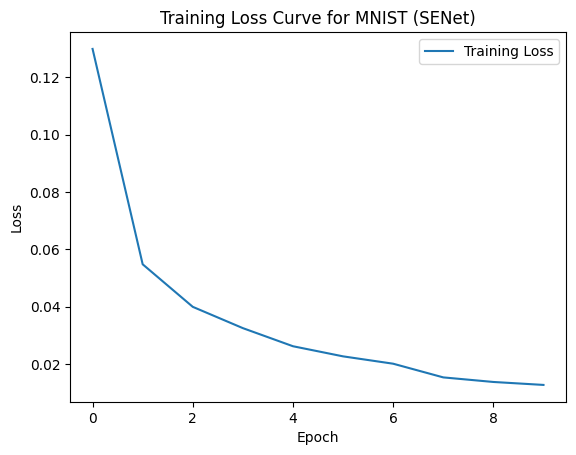

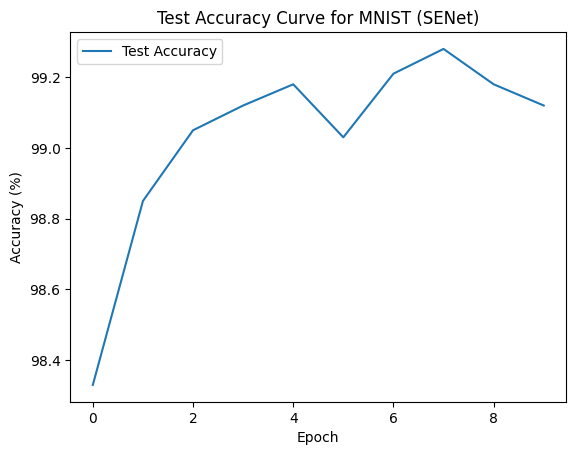

In [3]:
train_dataset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Device Configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Initialize Model, Loss Function, Optimizer
model = SENet(num_classes=10).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training and Evaluation
num_epochs = 10
train_loss_list = []
test_accuracy_list = []

for epoch in range(num_epochs):
    print(f'Epoch {epoch + 1}/{num_epochs}')
    # Training
    model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    train_loss = running_loss / len(train_loader)
    train_loss_list.append(train_loss)
    print(f'Training Loss: {train_loss:.4f}')

    # Testing
    model.eval()
    correct = 0
    total = 0
    y_true, y_pred = [], []
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())

    accuracy = 100 * correct / total
    test_accuracy_list.append(accuracy)
    print(f'Test Accuracy: {accuracy:.2f}%')

# Final Metrics Calculation
accuracy = accuracy_score(y_true, y_pred) * 100
precision = precision_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='weighted')
f1 = f1_score(y_true, y_pred, average='weighted')

# Print Final Metrics
print("\nFinal Metrics for MNIST using SENet:")
print(f"Accuracy: {accuracy:.2f}%")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")

# Plot Training Loss Curve
plt.figure()
plt.plot(train_loss_list, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Curve for MNIST (SENet)')
plt.legend()
plt.show()

# Plot Test Accuracy Curve
plt.figure()
plt.plot(test_accuracy_list, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Test Accuracy Curve for MNIST (SENet)')
plt.legend()
plt.show()

FMNIST

100%|██████████| 26.4M/26.4M [00:03<00:00, 7.26MB/s]


Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 29.5k/29.5k [00:00<00:00, 173kB/s]


Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 4.42M/4.42M [00:01<00:00, 3.11MB/s]


Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 5.15k/5.15k [00:00<00:00, 21.9MB/s]


Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw

Epoch 1/10
Training Loss: 0.4053
Test Accuracy: 88.89%
Epoch 2/10
Training Loss: 0.2668
Test Accuracy: 90.74%
Epoch 3/10
Training Loss: 0.2223
Test Accuracy: 91.65%
Epoch 4/10
Training Loss: 0.1880
Test Accuracy: 91.71%
Epoch 5/10
Training Loss: 0.1604
Test Accuracy: 92.13%
Epoch 6/10
Training Loss: 0.1351
Test Accuracy: 92.53%
Epoch 7/10
Training Loss: 0.1146
Test Accuracy: 92.74%
Epoch 8/10
Training Loss: 0.0967
Test Accuracy: 92.78%
Epoch 9/10
Training Loss: 0.0770
Test Accuracy: 93.14%
Epoch 10/10
Training Loss: 0.0673
Test Accuracy: 92.89%

Final Metrics for FMNIST using SENet:
Accuracy: 92.89%
Precision: 0.93
Recall: 0.93
F1 Score: 0.93


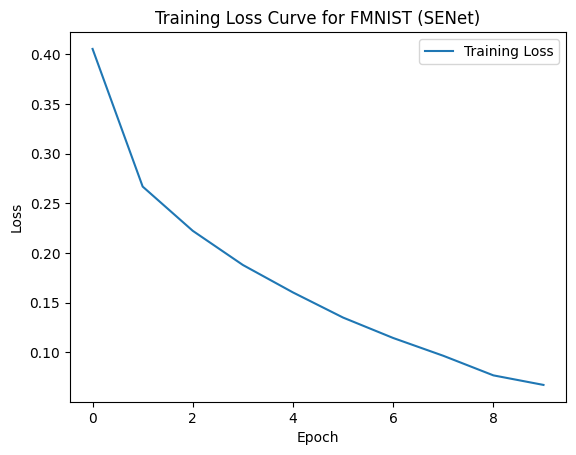

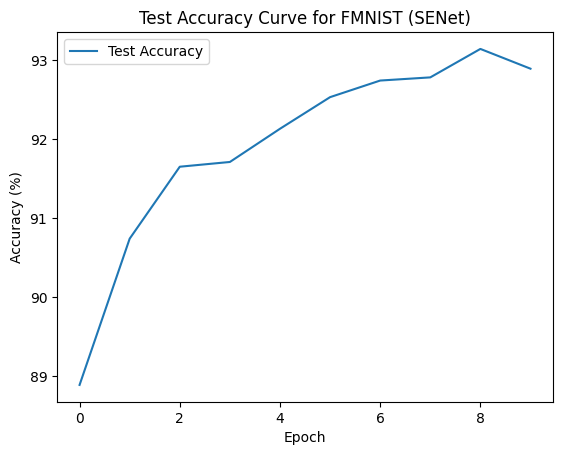

In [4]:
train_dataset = torchvision.datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Device Configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Initialize Model, Loss Function, Optimizer
model = SENet(num_classes=10).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training and Evaluation
num_epochs = 10
train_loss_list = []
test_accuracy_list = []

for epoch in range(num_epochs):
    print(f'Epoch {epoch + 1}/{num_epochs}')
    # Training
    model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    train_loss = running_loss / len(train_loader)
    train_loss_list.append(train_loss)
    print(f'Training Loss: {train_loss:.4f}')

    # Testing
    model.eval()
    correct = 0
    total = 0
    y_true, y_pred = [], []
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())

    accuracy = 100 * correct / total
    test_accuracy_list.append(accuracy)
    print(f'Test Accuracy: {accuracy:.2f}%')

# Final Metrics Calculation
accuracy = accuracy_score(y_true, y_pred) * 100
precision = precision_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='weighted')
f1 = f1_score(y_true, y_pred, average='weighted')

# Print Final Metrics
print("\nFinal Metrics for FMNIST using SENet:")
print(f"Accuracy: {accuracy:.2f}%")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")

# Plot Training Loss Curve
plt.figure()
plt.plot(train_loss_list, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Curve for FMNIST (SENet)')
plt.legend()
plt.show()

# Plot Test Accuracy Curve
plt.figure()
plt.plot(test_accuracy_list, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Test Accuracy Curve for FMNIST (SENet)')
plt.legend()
plt.show()

CIFAR-10

100%|██████████| 170M/170M [00:18<00:00, 9.11MB/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified
Epoch 1/20
Training Loss: 1.6109
Test Accuracy: 54.84%
Epoch 2/20
Training Loss: 1.3065
Test Accuracy: 64.19%
Epoch 3/20
Training Loss: 1.1423
Test Accuracy: 68.14%
Epoch 4/20
Training Loss: 1.0595
Test Accuracy: 70.25%
Epoch 5/20
Training Loss: 0.9950
Test Accuracy: 71.77%
Epoch 6/20
Training Loss: 0.9416
Test Accuracy: 71.71%
Epoch 7/20
Training Loss: 0.8998
Test Accuracy: 76.21%
Epoch 8/20
Training Loss: 0.8658
Test Accuracy: 74.85%
Epoch 9/20
Training Loss: 0.8280
Test Accuracy: 76.75%
Epoch 10/20
Training Loss: 0.8068
Test Accuracy: 76.67%
Epoch 11/20
Training Loss: 0.7814
Test Accuracy: 77.71%
Epoch 12/20
Training Loss: 0.7542
Test Accuracy: 77.59%
Epoch 13/20
Training Loss: 0.7322
Test Accuracy: 78.50%
Epoch 14/20
Training Loss: 0.7155
Test Accuracy: 79.16%
Epoch 15/20
Training Loss: 0.6962
Test Accuracy: 79.35%
Epoch 16/20
Training Loss: 0.6750
Test Accuracy: 79.58%
Epoch 17/20
Training Los

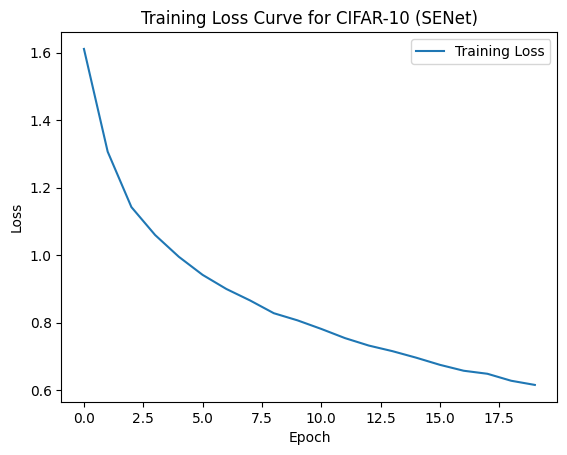

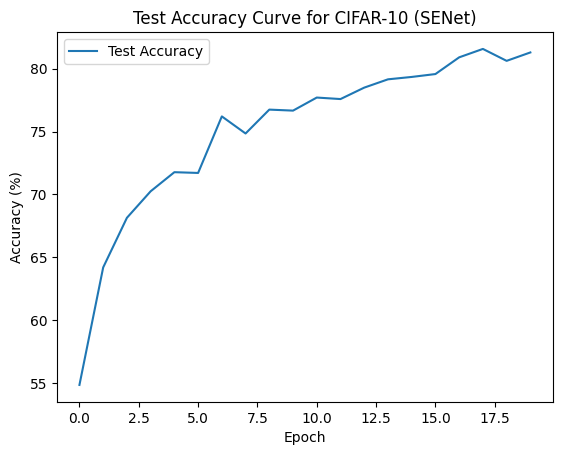

In [5]:
# Define SENet Architecture
class SENet(nn.Module):
    def __init__(self, num_classes=10):
        super(SENet, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1)  # Input: 32x32x3 -> Output: 32x32x64
        self.bn1 = nn.BatchNorm2d(64)
        self.se1 = SEBlock(64)

        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1)  # Output: 16x16x128
        self.bn2 = nn.BatchNorm2d(128)
        self.se2 = SEBlock(128)

        self.conv3 = nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1)  # Output: 8x8x256
        self.bn3 = nn.BatchNorm2d(256)
        self.se3 = SEBlock(256)

        self.fc = nn.Sequential(
            nn.Linear(256 * 8 * 8, 512),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        x = torch.relu(self.bn1(self.conv1(x)))
        x = self.se1(x)

        x = torch.relu(self.bn2(self.conv2(x)))
        x = self.se2(x)

        x = torch.relu(self.bn3(self.conv3(x)))
        x = self.se3(x)

        x = x.view(x.size(0), -1)  # Flatten
        x = self.fc(x)
        return x

# Data Transformations and CIFAR-10 Dataset
transform_train = transforms.Compose([
    transforms.RandomHorizontalFlip(),  # Data augmentation
    transforms.RandomCrop(32, padding=4),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalize RGB images
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Device Configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Initialize Model, Loss Function, Optimizer
model = SENet(num_classes=10).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training and Evaluation
num_epochs = 20
train_loss_list = []
test_accuracy_list = []

for epoch in range(num_epochs):
    print(f'Epoch {epoch + 1}/{num_epochs}')
    # Training
    model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    train_loss = running_loss / len(train_loader)
    train_loss_list.append(train_loss)
    print(f'Training Loss: {train_loss:.4f}')

    # Testing
    model.eval()
    correct = 0
    total = 0
    y_true, y_pred = [], []
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())

    accuracy = 100 * correct / total
    test_accuracy_list.append(accuracy)
    print(f'Test Accuracy: {accuracy:.2f}%')

# Final Metrics Calculation
accuracy = accuracy_score(y_true, y_pred) * 100
precision = precision_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='weighted')
f1 = f1_score(y_true, y_pred, average='weighted')

# Print Final Metrics
print("\nFinal Metrics for CIFAR-10 using SENet:")
print(f"Accuracy: {accuracy:.2f}%")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")

# Plot Training Loss Curve
plt.figure()
plt.plot(train_loss_list, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Curve for CIFAR-10 (SENet)')
plt.legend()
plt.show()

# Plot Test Accuracy Curve
plt.figure()
plt.plot(test_accuracy_list, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Test Accuracy Curve for CIFAR-10 (SENet)')
plt.legend()
plt.show()
